In [1]:
import warnings
warnings.simplefilter('ignore')

SAC_20100227_Chile_prem
Getting train embeddings
Training SVM
(449, 10) (449, 2)
Predicting on train embeddings with SVM
Predict          0      1      
Actual
0                97     5      

1                9      338    





Overall Statistics : 

95% CI                                                           (0.95274,0.9849)
AUNP                                                             0.96252
AUNU                                                             0.96252
Bennett_S                                                        0.93764
CBA                                                              0.94458
Chi-Squared                                                      374.02496
Chi-Squared DF                                                   1
Conditional Entropy                                              0.19826
Cramer_V                                                         0.9127
Cross Entropy                                                    0.77337
Gwet_AC1     

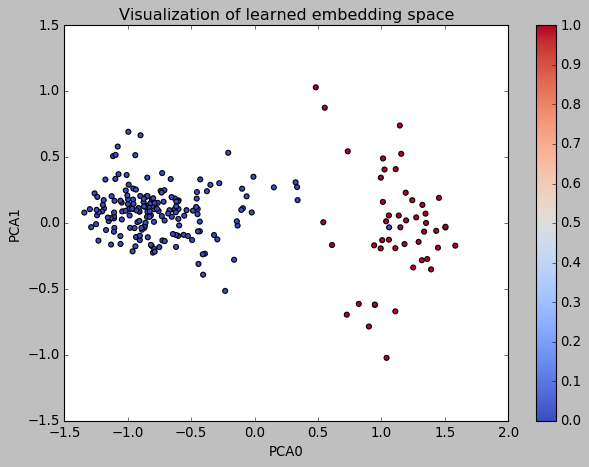

In [181]:
from dataset import EarthquakeDataset
import torch
from tqdm import trange, tqdm
import warnings
import pprint
import os
from torch.utils.data import DataLoader
from parser import construct_parser
import json
from networks import utils
from argparse import Namespace
import pickle
import numpy as np
import matplotlib
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GMM
from pycm import ConfusionMatrix
matplotlib.use('agg')
import matplotlib.pyplot as plt


pp = pprint.PrettyPrinter(indent=4)
torch.manual_seed(0)
warnings.simplefilter('ignore')
tqdm.monitor_interval = 0

# parser = construct_parser()
# args = parser.parse_args()

output_directory = '../pipelines/convolutional-siamese/runs/run57'
with open(os.path.join(output_directory, 'args.json'), 'r') as f:
    args = json.load(f)
print(args['split'])
args['output_directory'] = output_directory
    
    
args = Namespace(**args)

device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
dataset = EarthquakeDataset(folder=args.dataset_directory,
                            transforms=args.transforms,
                            augmentations='',
                            length=args.length,
                            mode='test',
                            split=args.split)
# dataset.toggle_split()
# max_length = 0
# for i in range(len(dataset)):
#     max_length = max(max_length, dataset[i]['data'].shape[-1])
# dataset.toggle_split()
# dataset.length = max_length
# print(dataset.length)

model, _, _ = utils.load_model(args.output_directory, device_target='cuda')
model.to(device)
model.eval()

def get_embeddings(dataset, model):
    dataloader = DataLoader(dataset,
                        batch_size=1,
                        num_workers=args.num_workers,
                        drop_last=False)
    
    epoch_loss = []
    embeddings = []
    
    labels = []
    for data_dict in dataloader:
        data = data_dict['data'].to(device).requires_grad_().float()
        label = data_dict['label'].to(device).float()
        output = model(data).squeeze(1)
        embeddings.append(output.cpu().data.numpy())
        labels.append(label.cpu().data.numpy())
    return np.vstack(embeddings), np.vstack(labels)

def train_svm(embeddings, labels):
    print(embeddings.shape, labels.shape)
    #svc = SVC(kernel='linear')
    svc = KNeighborsClassifier(n_neighbors=11)
    svc.fit(embeddings, np.argmax(labels, axis=-1))
    return svc

print('Getting train embeddings')
embeddings, labels = get_embeddings(dataset, model)
plt.clf()
pca = utils.visualize_embedding(embeddings, labels, os.path.join(args.output_directory, 'tr_viz.png'))

print('Training SVM')
svc = train_svm(embeddings, labels)

print('Predicting on train embeddings with SVM')
predictions = svc.predict(embeddings)
ground_truth = np.argmax(labels, axis=-1)

cm = ConfusionMatrix(predict_vector=predictions, actual_vector=ground_truth)
print(str(cm))

print('Getting test embeddings')
dataset.toggle_split()
embeddings, labels = get_embeddings(dataset, model)
plt.clf()
utils.visualize_embedding(embeddings, labels, os.path.join(args.output_directory, 'tt_viz.png'), pca=pca)

print('Predicting on test embeddings with SVM')
predictions = svc.predict(embeddings)
ground_truth = np.argmax(labels, axis=-1)

try:
    cm = ConfusionMatrix(predict_vector=predictions, actual_vector=ground_truth)
    results = str(cm)
except:
    results = str(sum(predictions == ground_truth) / len(ground_truth))

print('Results')
print(results)

with open(os.path.join(args.output_directory, 'results.txt'), 'w') as f:
    f.write(results)

In [188]:

data = dataset[10]['data']
target_length = 400
slack = int(target_length / 2)
argmax = 0 #int(data.argmax(axis=-1))
data = np.pad(data, ((0, 0), (slack, slack)), mode='constant')
distance_from_end = data.shape[-1] - argmax
distance_from_start = argmax


start = max(argmax - slack, 0)
stop = min(start + target_length, data.shape[-1])
data.shape, data[0, start:stop].shape, start, stop, argmax

((1, 12301), (400,), 0, 400, 0)

In [2]:
np.sqrt(1/dataset.get_prior())

array([1.1267932 , 2.16986943])

In [4]:
warnings.simplefilter('ignore')

181
32


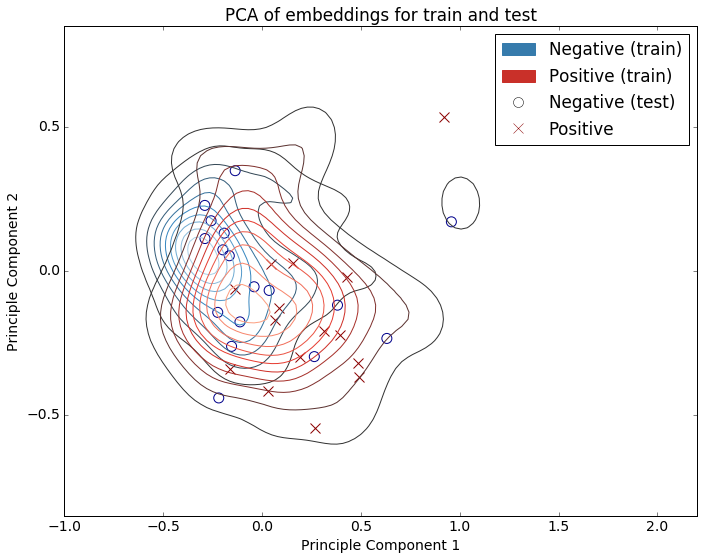

In [179]:
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib
%matplotlib inline

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)



dataset.toggle_split()
plt.figure(figsize=(10, 8))
print(len(dataset))
embeddings, labels = get_embeddings(dataset, model)
pca = PCA(n_components=2)
pca.fit(embeddings)
output = pca.transform(embeddings[labels.argmax(axis=-1) == 0])
sns.kdeplot(output[:, 0], output[:, 1], cmap="Blues_d", shade=False, shade_lowest=False, cut=3, gridsize=100)

label_patches = []

label_patch = mpatches.Patch(
        color=sns.color_palette('Blues_d')[2],
        label='Negative (train)')
label_patches.append(label_patch)

output = pca.transform(embeddings[labels.argmax(axis=-1) == 1])
sns.kdeplot(output[:, 0], output[:, 1], cmap="Reds_d", shade=False, shade_lowest=False, cut=3, gridsize=100)

label_patch = mpatches.Patch(
        color=sns.color_palette('Reds_d')[2],
        label='Positive (train)')
label_patches.append(label_patch)


dataset.toggle_split()
print(len(dataset))

embeddings, labels = get_embeddings(dataset, model)
output = pca.transform(embeddings[labels.argmax(axis=-1) == 0])
plt.scatter(output[:, 0], output[:, 1], color='darkblue', marker='o', facecolors='none', edgecolors='darkblue',s=100)

label_patches.append(mlines.Line2D([], [], color='darkblue', marker='o',markerfacecolor='none', linestyle='None',
                          markersize=10, label='Negative (test)'))

output = pca.transform(embeddings[labels.argmax(axis=-1) == 1])
plt.scatter(output[:, 0], output[:, 1], color='darkred', marker='x', edgecolors='darkred', s=100)

label_patches.append(mlines.Line2D([], [], color='darkred', marker='x', linestyle='None',
                          markersize=10, label='Positive'))

plt.title('PCA of embeddings for train and test')
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')


plt.legend(handles=label_patches, numpoints=1)

plt.xlim([-1.0, 2.2])
plt.ylim([-.85, .85])

plt.tight_layout()
plt.savefig(os.path.join(args.output_directory, 'tt_tr_viz.png'))

plt.show()



In [42]:
output[np.argmax(np.sum(np.abs(output) ** 2, axis=-1))]

array([0.7731464, 1.7599466], dtype=float32)

In [39]:
dataset[7]

{'data': array([[ 1.27054654,  0.88693869, -1.52393677, ...,  0.20068432,
         -0.97244142,  0.46103888]]),
 'label': array([1., 0.]),
 'weight': 2.0980850279037133}

226


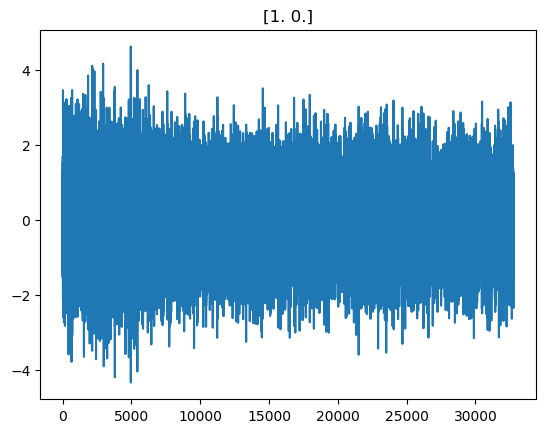

In [40]:
print(len(dataset.files))
i = 7 #np.random.randint(0,len(dataset))
x = dataset[i]
np.max(np.abs(x['data']))


%matplotlib inline
plt.style.use('default')
plt.plot(x['data'].flatten())
plt.title((x['label']))#, predictions[i]))
plt.show()

1

In [26]:
x['data'].std()

2.2379350438324983

In [17]:
from torch import nn
m = nn.AvgPool1d(10)
input = torch.randn(20, 1, 10000)
output = m(input)
print(input.shape, output.shape)

torch.Size([20, 1, 10000]) torch.Size([20, 1, 1000])
